In [6]:
# pip install keras

In [7]:
# pip install tensorflow

In [8]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [9]:
df = pd.read_csv('model_modified.csv')
df.head()

,Date,Price
0,2014-01-01,38.21
1,2014-01-02,37.61
2,2014-01-03,37.01
3,2014-01-06,36.63
4,2014-01-07,35.41


In [10]:
df.tail()

,Date,Price
2556,2024-05-06,167.45
2557,2024-05-07,164.25
2558,2024-05-08,166.05
2559,2024-05-09,161.90
2560,2024-05-10,162.40


In [11]:
cop = df.reset_index()['Price']
cop

0        38.21
1        37.61
2        37.01
3        36.63
4        35.41
         ...  
2556    167.45
2557    164.25
2558    166.05
2559    161.90
2560    162.40
Name: Price, Length: 2561, dtype: float64

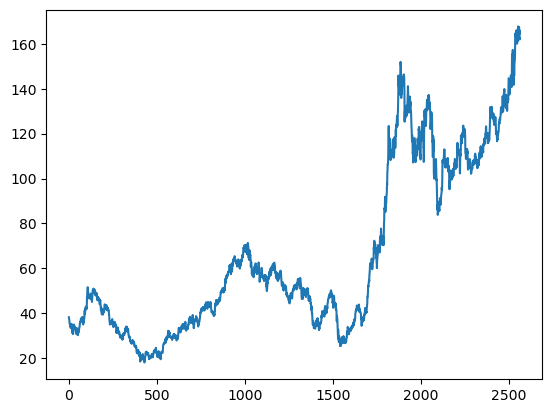

In [12]:
plt.plot(cop)

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
cop = scaler.fit_transform(np.array(cop).reshape(-1,1))

In [14]:
len(cop)

2561

In [15]:
trainingSize = int(len(cop)*0.80)
testSize = len(cop)-trainingSize

train_data, test_data = cop[0:trainingSize,:],cop[trainingSize:len(cop),:1]

In [16]:
len(train_data),len(test_data)

(2048, 513)

In [17]:
def create_data(data,time_step):
    X, y = [],[]
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        b = data[i+time_step,0]
        X.append(a)
        y.append(b)

    return np.array(X), np.array(y)

In [18]:
time_step = 100
X_train, y_train = create_data(train_data,time_step)
X_test, y_test = create_data(test_data,time_step)

In [19]:
print(X_train.shape), print(X_test.shape)

(1947, 100)
(412, 100)


(None, None)

In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [22]:
def buildModel(input_shape):
    input_layer = Input(shape=input_shape)
    model = LSTM(units=128,return_sequences=True)(input_layer)
    model = Dropout(0.2)(model)
    model = LSTM(units=128,return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = LSTM(units=128,return_sequences=False)(model)
    model = Dropout(0.2)(model)
    model = Dense(64,activation='relu')(model)
    model = Dropout(0.2)(model)
    model = Dense(64,activation='relu')(model)
    output_layer = Dense(1)(model)
    neuron = Model(inputs=input_layer,outputs=output_layer)
    neuron.compile(loss='mean_squared_error',optimizer='adam')
    return neuron

In [23]:
clf = buildModel((100,1))
clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,209 (1.31 MB)

 Trainable params: 342,209 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
hist = clf.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - loss: 0.0308 - val_loss: 0.0027
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 

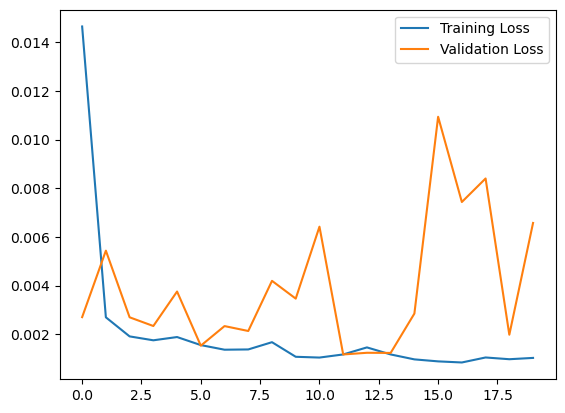

In [25]:
plt.plot(hist.history['loss'],label='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [26]:
train_predict=clf.predict(X_train)
test_predict=clf.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


In [27]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

58.6455956929186

In [29]:
math.sqrt(mean_squared_error(y_test,test_predict))

112.45105929064263

In [30]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae = mean_absolute_error(y_train,train_predict)
maep = mean_absolute_percentage_error(y_train,train_predict)
print(mae,maep)

52.52960711765291 57756351016227.805


In [31]:
mae_pred = mean_absolute_error(y_test,test_predict)
maep_pred = mean_absolute_percentage_error(y_test,test_predict)
print(mae_pred,maep_pred)

111.75747835117583 162.80586058143254


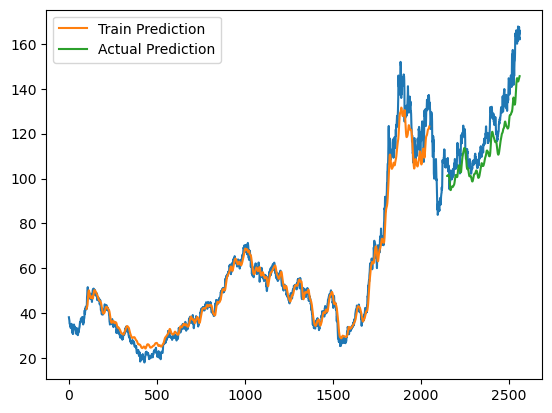

In [32]:
look_back=100
trainPredictPlot = np.empty_like(cop)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(cop)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(cop)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(cop))
plt.plot(trainPredictPlot,label='Train Prediction')
plt.plot(testPredictPlot, label='Actual Prediction')
plt.legend()
plt.show()


In [33]:
len(test_data)

513

In [39]:
x_input = test_data[413:].reshape(1,-1)
x_input.shape

(1, 100)

In [40]:
temp_in = list(x_input)
temp_in = temp_in[0].tolist()

In [41]:
temp_in

[0.7614114816547484,
 0.7911515070507251,
 0.7921539798168816,
 0.7841341976876296,
 0.7463743901624006,
 0.7547283298803716,
 0.7717703669050325,
 0.7827975673327541,
 0.7961638708815076,
 0.8025128650671658,
 0.812203435140012,
 0.8138742230836062,
 0.812203435140012,
 0.7838000400989107,
 0.7764485731470963,
 0.7724386820824701,
 0.7614114816547484,
 0.7724386820824701,
 0.7754461003809396,
 0.7807926218004412,
 0.7834658825101919,
 0.7807926218004412,
 0.7964980284702265,
 0.7590723785337166,
 0.7547283298803716,
 0.7764485731470963,
 0.7744436276147831,
 0.7487134932834325,
 0.7824634097440354,
 0.7731069972599078,
 0.7814609369778788,
 0.7794559914455657,
 0.7878099311635367,
 0.7801243066230035,
 0.8061885985430729,
 0.8252355811000469,
 0.8459533516006149,
 0.8442825636570207,
 0.8392701998262382,
 0.8235647931564527,
 0.7975005012363832,
 0.8005079195348527,
 0.8228964779790149,
 0.8228964779790149,
 0.8302479449308295,
 0.8279088418097975,
 0.8218940052128585,
 0.840940987769

In [48]:
lst_output=[]
n_steps=100
i=0
while(i<1):
    
    if(len(temp_in)>100):
        #print(temp_input)
        x_input=np.array(temp_in[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = clf.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_in.extend(yhat[0].tolist())
        temp_in=temp_in[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = clf.predict(x_input, verbose=0)
        print(yhat[0])
        temp_in.extend(yhat[0].tolist())
        print(len(temp_in))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.81220344 0.81387422 0.81220344 0.78380004 0.77644857 0.77243868
 0.76141148 0.77243868 0.7754461  0.78079262 0.78346588 0.78079262
 0.79649803 0.75907238 0.75472833 0.77644857 0.77444363 0.74871349
 0.78246341 0.773107   0.78146094 0.77945599 0.78780993 0.78012431
 0.8061886  0.82523558 0.84595335 0.84428256 0.8392702  0.82356479
 0.7975005  0.80050792 0.82289648 0.82289648 0.83024794 0.82790884
 0.82189401 0.84094099 0.85430729 0.85129987 0.83258705 0.84294593
 0.81988906 0.82055737 0.88137406 0.91679476 0.90242598 0.89407204
 0.89240126 0.93016106 0.90476509 0.89841609 0.8392702  0.83125042
 0.82623805 0.87970327 0.87335427 0.8526365  0.88237653 0.89373789
 0.89774778 0.89975272 0.92080465 0.96959166 0.97961639 0.97293324
 0.97126245 0.97092829 0.98329212 0.98863864 0.98228965 0.97193076
 0.95422041 0.94887389 0.94887389 0.96257435 0.96090356 0.95622536
 0.98563122 1.         0.98730201 0.99799505 0.98195549 0.9976609
 0.99198022 0.99832921 0.97694313 0.9889728  0.9612

In [49]:
scaled_pred = scaler.inverse_transform(lst_output)
print(scaled_pred)

[[125.36327304]]


In [50]:
len(cop)

2561

In [51]:
day_new=np.arange(1,101)
day_pred=np.arange(101,102)

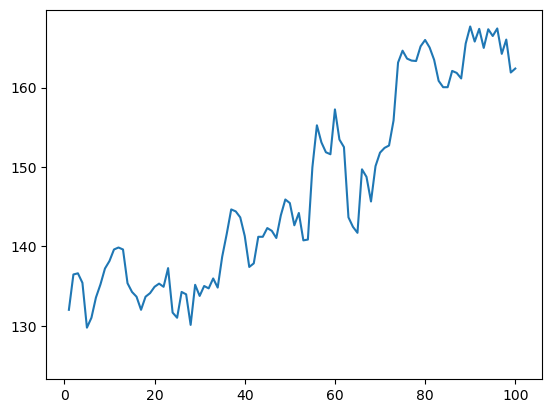

In [52]:
plt.plot(day_new,scaler.inverse_transform(cop[2461:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))